<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter07/Detectron2_Chapter07_Anchors.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 07 - Anchor Sizes and Ratios
## The dataset
Should execute the Notebook titled "Data Processing" first to process the dataset or run the following code to download the processed dataset from GitHub repository of the book.

In [ ]:
!wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/braintumors_coco.zip
!unzip -q braintumors_coco.zip

## Installation

In [ ]:
!python -m pip install \
'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kgmjkptk
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-kgmjkptk
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 154 kB 58.3 MB/s 
     |████████████████████████████████| 1.5 MB 54.2 MB/s 
     |████████████████████████████████| 549 kB 67.1 MB/s 
     |████████████████████████████████| 117 kB 79.5 MB/s 
     |████████████████████████████████| 96 kB 7.7 MB/s 
     |████████████████████████████████| 182 kB 66.1 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp38-cp38-linux_x86_64.whl size=5454901 sha256=68cae44e47841b4ce38b1ffa331166aa3fef3b83b493743125bdf39c879e2b70
  Stored in directory: /tmp/pip-ephem-wheel-cache-p5eku9z_/wheels/19/ac/6

## Register datasets

In [ ]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()

In [ ]:
from detectron2.data.datasets import register_coco_instances

In [ ]:
# Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
image_root_train = name_ds + "/train"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af

In [ ]:
# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )

### Training configuration

In [ ]:
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

In [ ]:
output_dir = "output/object_detector_hook"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 2
device = "cuda"
# Select a model
config_file_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [ ]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
# Workers
cfg.DATALOADER.NUM_WORKERS = 2
# Images per batch
cfg.SOLVER.IMS_PER_BATCH = 6
# Learning rate
cfg.SOLVER.BASE_LR = 0.00025
# Iterations
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.CHECKPOINT_PERIOD = 500
# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

### A trainer

In [ ]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg)

[12/28 00:38:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Preprocessing Input Images

In [ ]:
print("MIN_SIZE_TRAIN", cfg.INPUT.MIN_SIZE_TRAIN)
print("MAX_SIZE_TRAIN", cfg.INPUT.MAX_SIZE_TRAIN)

MIN_SIZE_TRAIN (640, 672, 704, 736, 768, 800)
MAX_SIZE_TRAIN 1333


In [ ]:
trainer._data_loader_iter = iter(trainer.data_loader)
data = next(trainer._data_loader_iter)
for i in data:
  print(i['image'].shape)

torch.Size([3, 704, 704])
torch.Size([3, 672, 672])
torch.Size([3, 800, 800])
torch.Size([3, 800, 800])
torch.Size([3, 736, 736])
torch.Size([3, 736, 736])


In [ ]:
images = trainer.model.preprocess_image(data)
print(images.tensor.shape)

torch.Size([6, 3, 800, 800])


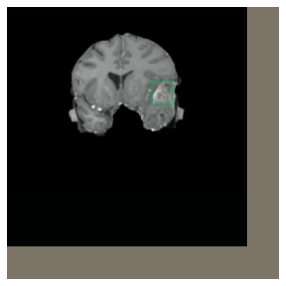

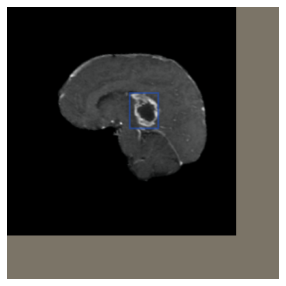

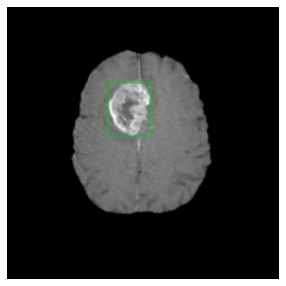

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

for i, item in enumerate(images.tensor[:3]):
  img = np.moveaxis(item.to("cpu").numpy(), 0, -1)
  pixel_mean = cfg.MODEL.PIXEL_MEAN
  pixel_std = cfg.MODEL.PIXEL_STD
  img = (img * pixel_std) + pixel_mean
  v = Visualizer(img, metadata={}, scale=0.5)
  v = v.overlay_instances(boxes=data[i]['instances'].get('gt_boxes'))
  dpi = 80
  im_data = v.get_image()[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

## Sampling training data and generating the default anchors

In [ ]:
from tqdm import tqdm
import torch
def get_gt_boxes_batch(data):
  gt_boxes = [
      item['instances'].get('gt_boxes').tensor 
      for item in data
      ]
  return torch.concatenate(gt_boxes)

def get_gt_boxes(trainer, iterations):
  trainer._data_loader_iter = iter(trainer.data_loader)
  gt_boxes = [
      get_gt_boxes_batch(next(trainer._data_loader_iter)) 
      for _ in tqdm(range(iterations))
      ]
  return torch.concatenate(gt_boxes)
  
gt_boxes = get_gt_boxes(trainer, 1000)
print()
print(gt_boxes.shape)

100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


torch.Size([6323, 4])


In [ ]:
def boxes2wh(boxes):
  x1y1 = boxes[:, :2]
  x2y2 = boxes[:, 2:]
  return x2y2 - x1y1

gt_wh = boxes2wh(gt_boxes)
print(gt_wh.min(), gt_wh.max())

tensor(22.3098) tensor(299.3030)


In [ ]:
print("sizes", cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print("ratios", cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

sizes [[32], [64], [128], [256], [512]]
ratios [[0.5, 1.0, 2.0]]


In [ ]:
generate_anchors = trainer.model.proposal_generator.anchor_generator.generate_cell_anchors
anchors = generate_anchors()
ac_wh = boxes2wh(anchors)

## Generating sizes and ratios hyperparameters

In [ ]:
def wh2size(wh):
  return torch.sqrt(gt_wh[:, 0]*gt_wh[:, 1])

def wh2ratio(wh):
  return wh[:, 1]/wh[:,0]

gt_sizes = wh2size(gt_wh)
gt_ratios = wh2ratio(gt_wh)

In [ ]:
def best_ratio(ac_wh, gt_wh):
  all_ratios = gt_wh[:, None] / ac_wh[None]
  inverse_ratios = 1/all_ratios
  ratios = torch.min(
      all_ratios, inverse_ratios
  )
  worst = ratios.min(-1).values
  best = worst.max(-1).values
  return best

In [ ]:
def fitness(ac_wh, gt_wh, EDGE_RATIO_THRESHOLD = 0.25):
  ratio = best_ratio(ac_wh, gt_wh)
  return (ratio * (ratio > EDGE_RATIO_THRESHOLD).float()).mean()

In [ ]:
def best_recall(ac_wh, gt_wh, EDGE_RATIO_THRESHOLD = 0.25):
  ratio = best_ratio(ac_wh, gt_wh)
  best = (ratio > EDGE_RATIO_THRESHOLD).float().mean()
  return best

In [ ]:
print("recall", best_recall(ac_wh, gt_wh))
print("fitness", fitness(ac_wh, gt_wh))

recall tensor(1.)
fitness tensor(0.7838)


In [ ]:
import numpy as np
plt.rcParams["figure.dpi"] = 150
from scipy.cluster.vq import kmeans
def estimate_clusters(values, num_clusters, iter=100):
  std = values.std(0).item()
  k, _ = kmeans(values / std, num_clusters, iter=iter)
  k *= std
  return k

def visualize_clusters(values, centers):
  plt.hist(values, histtype='step')
  plt.scatter(centers, [0]*len(centers), c= "red")
  plt.show()

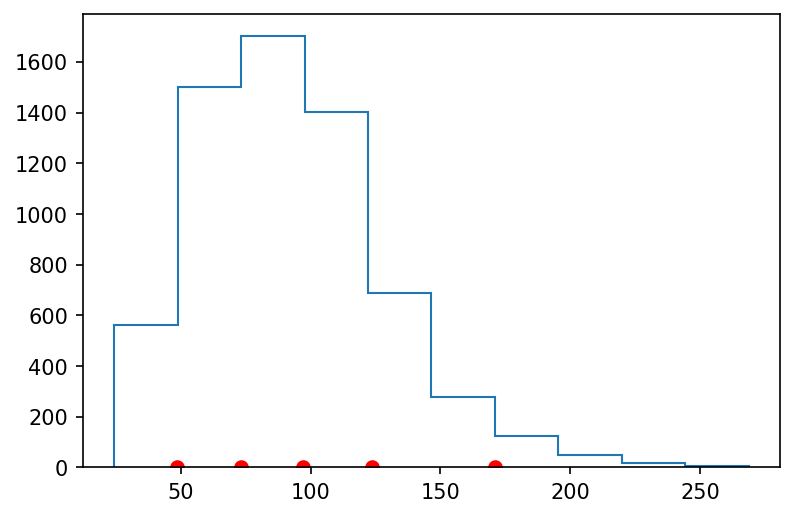

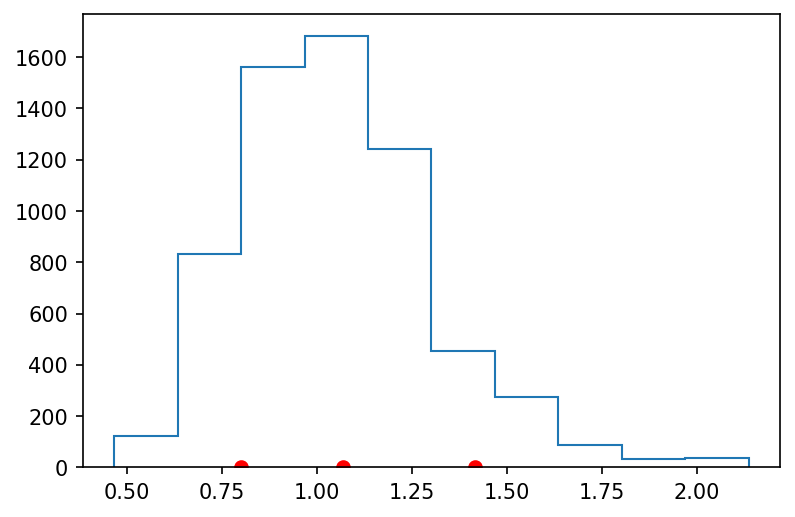

In [ ]:
sizes = estimate_clusters(gt_sizes, 5)
visualize_clusters(gt_sizes, sizes)
ratios = estimate_clusters(gt_ratios, 3)
visualize_clusters(gt_ratios, ratios)

In [ ]:
fitness(boxes2wh(generate_anchors(sizes, ratios)), gt_wh)

tensor(0.8786, dtype=torch.float64)


## Evolve the results using the Genetic Algorithm

In [ ]:
def evolve(sizes, ratios, 
           gt_wh, 
           iterations=10000, 
           probability=0.9, 
           muy=1, 
           sigma=0.05, 
           fit_fn=fitness, 
           verbose=False):
  anchors = generate_anchors(tuple(sizes), tuple(ratios))
  ac_wh = boxes2wh(anchors)
  best_fit = fit_fn(ac_wh, gt_wh)
  anchor_shape = len(sizes) + len(ratios)

  pbar = tqdm(range(iterations), desc=f"Evolving ratios and sizes:")
  for i, _ in enumerate(pbar):
      # to mutate and how much
      mutation = np.ones(anchor_shape)
      mutate = np.random.random(anchor_shape) < probability
      mutation = np.random.normal(muy, sigma, anchor_shape)*mutate
      mutation = mutation.clip(0.3, 3.0)
      # mutated
      mutated_sizes = sizes.copy()*mutation[:len(sizes)]
      mutated_ratios = ratios.copy()*mutation[-len(ratios):]
      mutated_anchors = generate_anchors(
          tuple(mutated_sizes), 
          tuple(mutated_ratios))
      mutated_ac_wh = boxes2wh(mutated_anchors)
      mutated_fit = fit_fn(mutated_ac_wh, gt_wh)

      if mutated_fit > best_fit:
        sizes = mutated_sizes.copy()
        ratios = mutated_ratios.copy()
        best_fit = mutated_fit
        pbar.desc = (f"Evolving ratios and sizes, Fitness = {best_fit:.4f}")
  return sizes, ratios

In [ ]:
e_sizes, e_ratios = evolve(sizes, ratios, gt_wh, verbose=False)

Evolving ratios and sizes, Fitness = 0.8835: 100%|██████████| 10000/10000 [00:30<00:00, 327.56it/s]


In [ ]:
print("sizes", e_sizes)
print("ratios", e_ratios)

sizes [ 68.33245953 112.91302277  89.55701886 144.71037342  47.77637482]
ratios [0.99819939 0.78726896 1.23598428]
